In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
import seaborn as sns

# Facebook _data_orange

In [3]:
with open('../../../data/official_pages/facebook_data_backup/orangemaroc_facebook_posts_with_comments_20250602_002729.json', 'r', encoding='utf-8') as f:
    data = json.load(f)["data"]

In [4]:
print(f"Type des données chargées : {type(data)}")

Type des données chargées : <class 'list'>


In [5]:
posts_df = pd.DataFrame(data if isinstance(data, list) else [data])
if 'comments' in posts_df.columns:
    posts_df = posts_df.drop(columns=['comments'])

#Convertir created_time en datetime
posts_df['created_time'] = pd.to_datetime(posts_df['created_time'])

In [6]:
posts_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   post_id              100 non-null    object        
 1   source_id            100 non-null    object        
 2   created_time         100 non-null    datetime64[ns]
 3   permalink            100 non-null    object        
 4   page_id              100 non-null    object        
 5   page_name            100 non-null    object        
 6   message              100 non-null    object        
 7   media_type           100 non-null    object        
 8   media_url            100 non-null    object        
 9   thumbnail_url        100 non-null    object        
 10  can_share            100 non-null    bool          
 11  shares               100 non-null    int64         
 12  can_comment          100 non-null    bool          
 13  comments_count       100 non-null   

In [7]:
posts_df.isnull().sum()

post_id                0
source_id              0
created_time           0
permalink              0
page_id                0
page_name              0
message                0
media_type             0
media_url              0
thumbnail_url          0
can_share              0
shares                 0
can_comment            0
comments_count         0
can_like               0
like_count             0
hashtags               0
mentions               0
platform               0
brand_name             0
kafka_metadata         0
collection_metadata    0
statistics             0
dtype: int64

In [9]:

# 1. Colonnes à vérifier pour présence de chaînes vides
text_fields = [
    "post_id", "source_id", "created_time", "permalink", "page_id",
    "page_name", "message", "media_type", "media_url", "thumbnail_url"
]

print("🧪 Champs texte vides :")
for col in text_fields:
    empty_count = (posts_df[col].astype(str).str.strip() == '').sum()
    print(f" - {col}: {empty_count} lignes vides")

# 2. Vérification created_time valide
print("\n🕒 Vérification des timestamps invalides :")
invalid_dates = pd.to_datetime(posts_df["created_time"], errors="coerce").isna().sum()
print(f" - created_time non valides : {invalid_dates}")

# 3. Valeurs uniques des booléens
print("\n🔁 Valeurs uniques booléennes :")
for col in ["can_share", "can_comment"]:
    print(f" - {col}: {posts_df[col].nunique()} valeurs uniques ({posts_df[col].unique()})")

# 4. Champs numériques à 0
print("\n🔢 Champs numériques avec des zéros :")
for col in ["shares", "comments_count", "like_count"]:
    zero_count = (posts_df[col] == 0).sum()
    print(f" - {col} == 0 : {zero_count} lignes")

# 5. Listes : type check et nombre de listes vides
print("\n📚 Vérification des champs listes :")
for col in ["hashtags", "mentions"]:
    non_lists = posts_df[~posts_df[col].apply(lambda x: isinstance(x, list))].shape[0]
    empty_lists = posts_df[posts_df[col].apply(lambda x: isinstance(x, list) and len(x) == 0)].shape[0]
    print(f" - {col} : {non_lists} non-listes / {empty_lists} listes vides")

🧪 Champs texte vides :
 - post_id: 0 lignes vides
 - source_id: 0 lignes vides
 - created_time: 0 lignes vides
 - permalink: 0 lignes vides
 - page_id: 0 lignes vides
 - page_name: 0 lignes vides
 - message: 1 lignes vides
 - media_type: 4 lignes vides
 - media_url: 7 lignes vides
 - thumbnail_url: 4 lignes vides

🕒 Vérification des timestamps invalides :
 - created_time non valides : 0

🔁 Valeurs uniques booléennes :
 - can_share: 1 valeurs uniques ([ True])
 - can_comment: 1 valeurs uniques ([ True])

🔢 Champs numériques avec des zéros :
 - shares == 0 : 0 lignes
 - comments_count == 0 : 0 lignes
 - like_count == 0 : 0 lignes

📚 Vérification des champs listes :
 - hashtags : 0 non-listes / 14 listes vides
 - mentions : 0 non-listes / 100 listes vides


In [10]:
posts_df = posts_df.drop(columns=["kafka_metadata", "collection_metadata", "statistics"])

In [11]:
 #Ajouter des colonnes utiles
posts_df['day'] = posts_df['created_time'].dt.date
posts_df['hour'] = posts_df['created_time'].dt.hour
posts_df['message_length'] = posts_df['message'].fillna('').apply(len)

In [12]:
#Aperçu général
print(posts_df.describe(include='all'))
print(posts_df.dtypes)
print(posts_df.head())
print(posts_df["post_id"].nunique())

                 post_id        source_id                   created_time  \
count                100              100                            100   
unique               100                1                            NaN   
top     1093948522770550  100064662374992                            NaN   
freq                   1              100                            NaN   
mean                 NaN              NaN  2025-03-20 01:38:01.169999872   
min                  NaN              NaN            2025-01-24 13:33:30   
25%                  NaN              NaN  2025-02-26 11:14:18.750000128   
50%                  NaN              NaN     2025-03-19 15:10:45.500000   
75%                  NaN              NaN  2025-04-13 07:01:10.750000128   
max                  NaN              NaN            2025-05-28 15:20:10   
std                  NaN              NaN                            NaN   

                                                permalink          page_id  \
count    

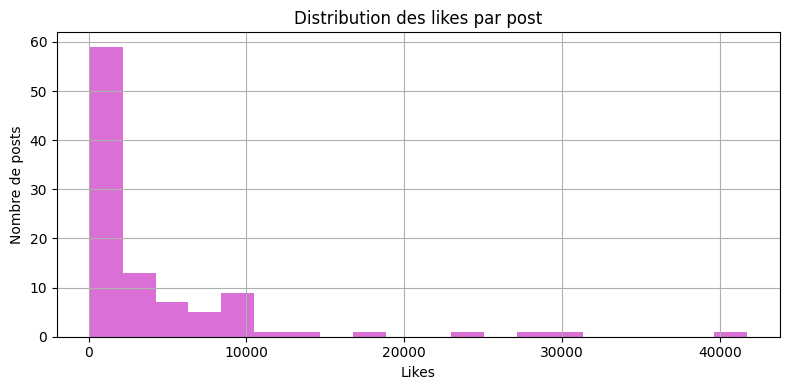

In [13]:

# 1. Histogramme des likes
plt.figure(figsize=(8, 4))
plt.hist(posts_df['like_count'], bins=20, color='orchid')
plt.title("Distribution des likes par post")
plt.xlabel("Likes")
plt.ylabel("Nombre de posts")
plt.grid(True)
plt.tight_layout()
plt.show()

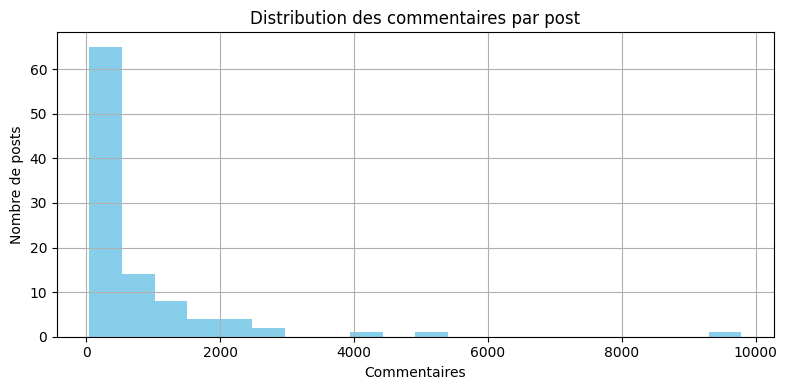

In [14]:
plt.figure(figsize=(8, 4))
plt.hist(posts_df['comments_count'], bins=20, color='skyblue')
plt.title("Distribution des commentaires par post")
plt.xlabel("Commentaires")
plt.ylabel("Nombre de posts")
plt.grid(True)
plt.tight_layout()
plt.show()

     month  count
0  2025-01      8
1  2025-02     21
2  2025-03     40
3  2025-04     20
4  2025-05     11


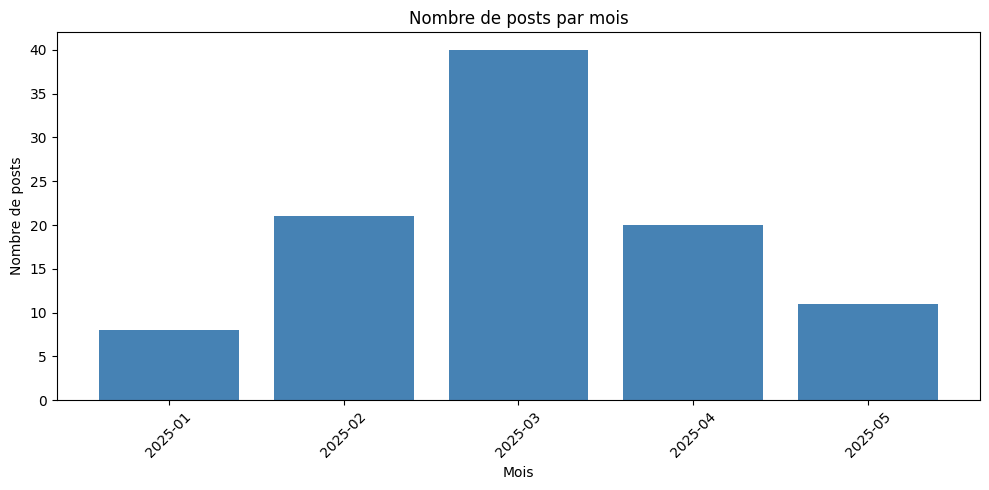

In [15]:
posts_df['month'] = posts_df['created_time'].dt.to_period('M').astype(str)

# 3. Compter les posts par mois
posts_per_month = posts_df.groupby('month').size().reset_index(name='count')

# 4. Afficher les valeurs
print(posts_per_month)

# 5. Visualisation
plt.figure(figsize=(10, 5))
plt.bar(posts_per_month['month'], posts_per_month['count'], color='steelblue')
plt.title("Nombre de posts par mois")
plt.xlabel("Mois")
plt.ylabel("Nombre de posts")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

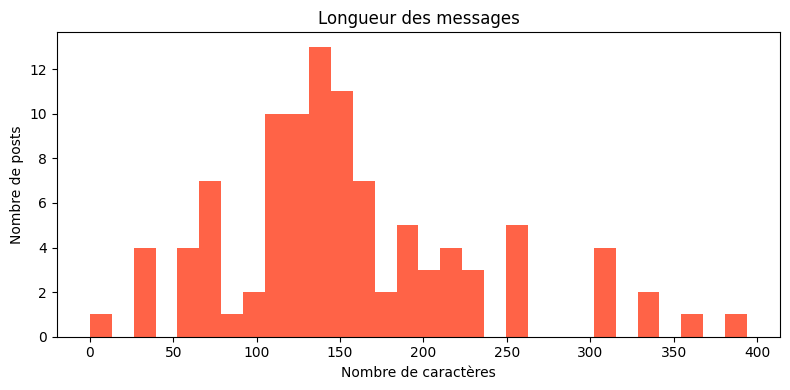

In [16]:
# Longueur des messages
plt.figure(figsize=(8, 4))
plt.hist(posts_df['message_length'], bins=30, color='tomato')
plt.title("Longueur des messages")
plt.xlabel("Nombre de caractères")
plt.ylabel("Nombre de posts")
plt.tight_layout()
plt.show()

In [23]:
def parse_count(value):
    if not value:
        return 0
    if isinstance(value, int):
        return value
    if isinstance(value, float):
        return int(value)
    value = str(value).strip().upper()
    try:
        if value.endswith('K') or value.endswith('k') :
            return int(float(value[:-1]) * 1000)
        elif value.endswith('M'):
            return int(float(value[:-1]) * 1_000_000)
        else:
            return int(value)
    except ValueError:
        return 0

In [ ]:
all_comments = []

for post in data:
    comments = post.get('comments', [])
    
    # Vérifie que la liste n'est pas vide
    if comments:
        for comment in comments:
            # Extraire uniquement les commentaires avec metadata valide
            metadata = comment.get('comment_metadata', {})
            if 'parent_post_id' in metadata:
                comment_flat = {
                    'comment_id': comment.get('comment_id'),
                    'message': comment.get('message'),
                    'created_time': comment.get('created_time'),
                   'like_count': parse_count(comment.get('like_count', 0)),
                'reply_count': parse_count(comment.get('reply_count', 0)),
                    'user_id': comment.get('user_id'),
                    'user_name': comment.get('user_name'),
                    'comment_url': comment.get('comment_url'),
                    'parent_post_id': metadata['parent_post_id'],
                    'comment_length': metadata.get('comment_length'),
                    'comment_engagement_score': metadata.get('comment_engagement_score'),
                    'has_hashtags': metadata.get('has_hashtags'),
                    'has_mentions': metadata.get('has_mentions'),
                    'platform': comment.get('platform'),
                    'brand_name': comment.get('brand_name')
                }
                all_comments.append(comment_flat)

# Créer le DataFrame à partir de la liste
comments_df = pd.DataFrame(all_comments)

# Conversion en datetime
comments_df['created_time'] = pd.to_datetime(comments_df['created_time'])

# Aperçu
print(comments_df.head())

ValueError: invalid literal for int() with base 10: '1K'

In [18]:
comments_df.info()

NameError: name 'comments_df' is not defined

In [21]:
comments_df["comment_id"].nunique()

20774

In [19]:
# 1. Trouver les comment_id dupliqués
duplicated_ids = comments_df['comment_id'][comments_df['comment_id'].duplicated()]

# 2. Accéder aux lignes complètes avec ces comment_id
duplicated_comments = comments_df[comments_df['comment_id'].isin(duplicated_ids)]

# 3. Afficher les résultats
print(f"Nombre de commentaires dupliqués : {duplicated_comments.shape[0]}")
print(duplicated_comments[['comment_id', 'message', 'created_time']])


NameError: name 'comments_df' is not defined

In [20]:
print(comments_df.shape)
print(comments_df.dtypes)
comments_df.head()

NameError: name 'comments_df' is not defined

In [21]:

plt.figure(figsize=(8,4))
sns.histplot(comments_df['comment_length'], bins=30, kde=True)
plt.title("Distribution de la longueur des commentaires")
plt.xlabel("Nombre de caractères")
plt.ylabel("Fréquence")
plt.show()

NameError: name 'comments_df' is not defined

<Figure size 800x400 with 0 Axes>

In [22]:
message = comments_df[comments_df["comment_length"] > 4000]["message"].iloc[0]
print(message)


NameError: name 'comments_df' is not defined

In [ ]:
# 1. Colonnes texte à vérifier
text_fields = [
    "comment_id", "user_id", "user_name", "message", "created_time"
]

print("🧪 Champs texte vides (commentaires) :")
for col in text_fields:
    empty_count = (comments_df[col].astype(str).str.strip() == '').sum()
    print(f" - {col}: {empty_count} lignes vides")

# 2. Vérification created_time valide
print("\n🕒 Vérification des timestamps invalides (commentaires) :")
invalid_dates = pd.to_datetime(comments_df["created_time"], errors="coerce").isna().sum()
print(f" - created_time non valides : {invalid_dates}")

# 3. Valeurs uniques des booléens (si existent, ex: can_like, peut être adapté à ton cas)
bool_fields = [col for col in ["can_like"] if col in comments_df.columns]

print("\n🔁 Valeurs uniques booléennes (commentaires) :")
for col in bool_fields:
    print(f" - {col}: {comments_df[col].nunique()} valeurs uniques ({comments_df[col].unique()})")

# 4. Champs numériques : valeurs à 0
numeric_fields = [col for col in ["like_count", "reply_count"] if col in comments_df.columns]

print("\n🔢 Champs numériques avec des zéros (commentaires) :")
for col in numeric_fields:
    zero_count = (comments_df[col] == 0).sum()
    print(f" - {col} == 0 : {zero_count} lignes")

# 5. Listes : hashtags et mentions dans les commentaires (si présents)
list_fields = [col for col in ["hashtags", "mentions"] if col in comments_df.columns]

print("\n📚 Vérification des champs listes (commentaires) :")
for col in list_fields:
    non_lists = comments_df[~comments_df[col].apply(lambda x: isinstance(x, list))].shape[0]
    empty_lists = comments_df[comments_df[col].apply(lambda x: isinstance(x, list) and len(x) == 0)].shape[0]
    print(f" - {col} : {non_lists} non-listes / {empty_lists} listes vides")

🧪 Champs texte vides (commentaires) :
 - comment_id: 0 lignes vides
 - user_id: 0 lignes vides
 - user_name: 0 lignes vides
 - message: 466 lignes vides
 - created_time: 0 lignes vides

🕒 Vérification des timestamps invalides (commentaires) :
 - created_time non valides : 0

🔁 Valeurs uniques booléennes (commentaires) :

🔢 Champs numériques avec des zéros (commentaires) :
 - like_count == 0 : 16570 lignes
 - reply_count == 0 : 16336 lignes

📚 Vérification des champs listes (commentaires) :
